# Version 3 Notes

* Images still resized to 128x128 for all models expect Model 9 (Ash's)
* Pixels not normalized for any model (excluding Model 9)

* Training with Augmented (bigger set)
* Testing with Original (smaller set)

* Ash's Model used data that was resized to 224x224 and was normalized
* Accuracies and validation scores high, but F1 scores still low

* #### Changes from Version 2: Switched testing and training datasets so it was training on the much bigger set, and Ash's used a different preprocessing method as a test

* #### Issues: Not normalizing the pixels might be an issue, as well as the size of the rescaling, class imbalance might also be a problem?

In [1]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
! pip install pandas


  Using cached tensorflow-2.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached grpcio-1.68.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metada

# Import Libraries and Dataset

In [2]:
# Importing all necessary libraries
import os
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-17 04:16:11.358891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 04:16:11.363416: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 04:16:11.378111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731816971.400181     708 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731816971.405392     708 cuda_blas.c

# Importing the data to be used in this CNN

In [3]:
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")
print("Path to dataset files:", path)

100%|██████████| 380M/380M [00:04<00:00, 82.6MB/s] 

Extracting files...


Path to dataset files: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


# Splitting Data to Training and Testing set

In [4]:
# Set the base path
test_dir = os.path.join(path, 'OriginalDataset')
train_dir = os.path.join(path, 'AugmentedAlzheimerDataset')

print("Train Directory:", train_dir)
print("Test Directory:", test_dir)

Train Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset
Test Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/OriginalDataset


In [5]:
# viewing the data provided
print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))

Train directory contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Test directory contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# File Counts in Test/Train

In [6]:
# count the files inside each class directory
train_files = sum([len(files) for _, _, files in os.walk(train_dir)])
test_files = sum([len(files) for _, _, files in os.walk(test_dir)])

print(f"Train files count: {train_files}")
print(f"Test files count: {test_files}")

Train files count: 33984
Test files count: 6400


# Preprocessing Training and Testing Datasets

In [29]:
# Load datasets using categorical labels
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),          # resize all images to 128x128 pixels
    batch_size=32,                  # load images in batches of 32 for efficient processing
    label_mode='categorical',       # assign categorical labels to each image (one-hot encoded)
    shuffle=True,                   # shuffle the dataset to promote model generalization
)

class_names = train_dataset.class_names
print("Class Names:", class_names)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical',
    shuffle=False,                  # do not shuffle to maintain consistent evaluation order
)

Found 33984 files belonging to 4 classes.


Class Names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Found 6400 files belonging to 4 classes.


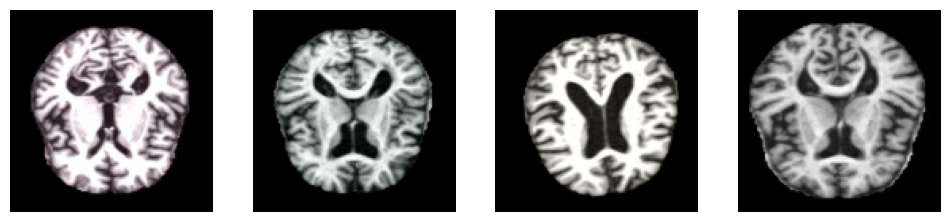

In [8]:
# Visualizing the first 4 images (without shuffling)

for images, labels in train_dataset.take(1):  # Take one batch
    plt.figure(figsize=(12, 4))  # Set the figure size for 4 images
    for i in range(4):  # Loop to display the first 4 images
        plt.subplot(1, 4, i+1)  # Create a 1x4 grid for images
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.axis('off')  # Turn off axis
    plt.show()
    break  # Only process the first batch

# Validation and Training Sets

In [9]:
# Split train_dataset into training and validation sets
val_size = int(0.2 * len(train_dataset))  # Use 20% of training data for validation
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

# Verify dataset sizes
print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Testing batches: {len(test_dataset)}")

Training batches: 850
Validation batches: 212
Testing batches: 200


# Looking at Class Imbalance

In [37]:
from collections import Counter
import numpy as np

# Count samples in the training dataset
train_counts = Counter()
for _, labels in train_dataset:
    train_counts.update(np.argmax(labels.numpy(), axis=-1))

# Map class indices to class names
train_distribution = {class_names[i]: train_counts[i] for i in range(len(class_names))}

# Count samples in the validation dataset
val_counts = Counter()
for _, labels in val_dataset:
    val_counts.update(np.argmax(labels.numpy(), axis=-1))

val_distribution = {class_names[i]: val_counts[i] for i in range(len(class_names))}

# Count samples in the test dataset
test_counts = Counter()
for _, labels in test_dataset:
    test_counts.update(np.argmax(labels.numpy(), axis=-1))

test_distribution = {class_names[i]: test_counts[i] for i in range(len(class_names))}

# Print distributions
print("Training Data Distribution:", train_distribution)
print("Validation Data Distribution:", val_distribution)
print("Testing Data Distribution:", test_distribution)



Training Data Distribution: {'MildDemented': 8960, 'ModerateDemented': 6464, 'NonDemented': 9600, 'VeryMildDemented': 8960}
Validation Data Distribution: {'MildDemented': 1873, 'ModerateDemented': 1289, 'NonDemented': 1901, 'VeryMildDemented': 1721}
Testing Data Distribution: {'MildDemented': 896, 'ModerateDemented': 64, 'NonDemented': 3200, 'VeryMildDemented': 2240}


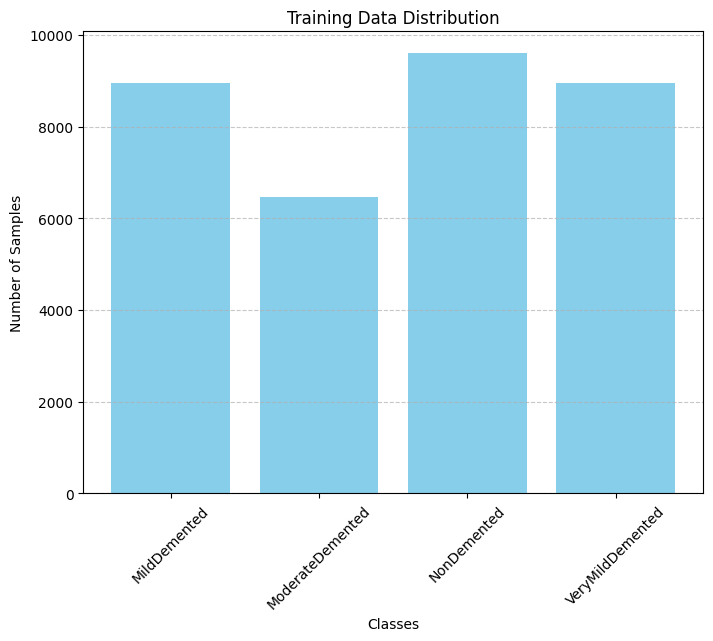

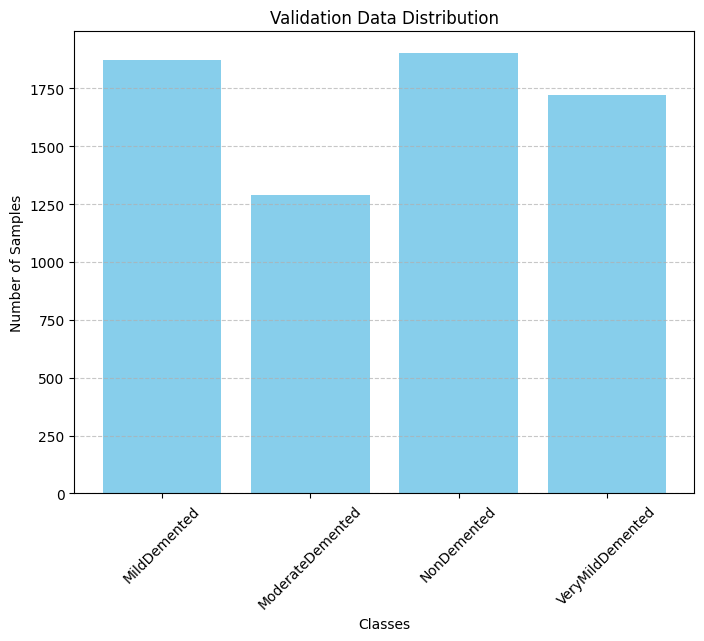

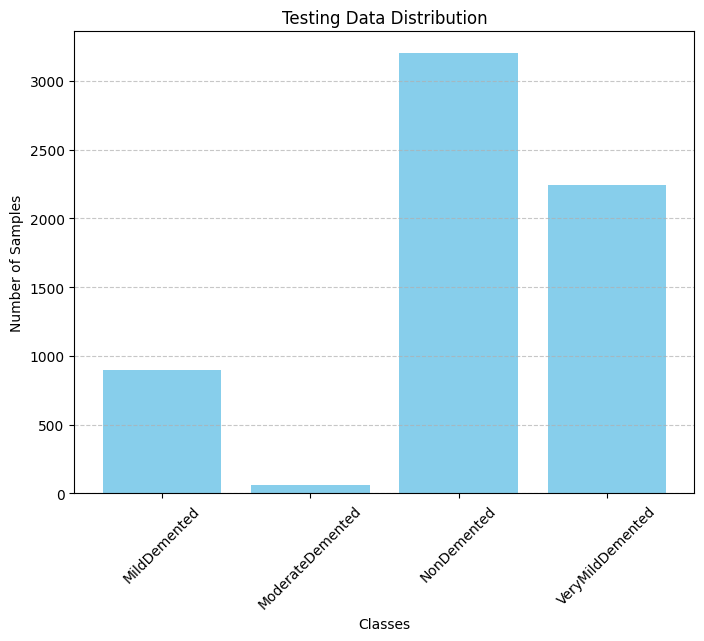

In [38]:
import matplotlib.pyplot as plt

# Visualize distributions
def plot_distributions(distributions, title):
    plt.figure(figsize=(8, 6))
    plt.bar(distributions.keys(), distributions.values(), color='skyblue')
    plt.title(title)
    plt.ylabel("Number of Samples")
    plt.xlabel("Classes")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_distributions(train_distribution, "Training Data Distribution")
plot_distributions(val_distribution, "Validation Data Distribution")
plot_distributions(test_distribution, "Testing Data Distribution")


# Model 1: Basic CNN

In [10]:
# Model 1: Basic CNN
model_1 = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(train_dataset, validation_data=val_dataset, epochs=10)


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 217s 251ms/step - accuracy: 0.3917 - loss: 3.3063 - val_accuracy: 0.6060 - val_loss: 0.8820
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.6288 - loss: 0.8172 - val_accuracy: 0.6922 - val_loss: 0.6802
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 123s 143ms/step - accuracy: 0.7232 - loss: 0.6162 - val_accuracy: 0.7714 - val_loss: 0.5297
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 130s 151ms/step - accuracy: 0.7942 - loss: 0.4864 - val_accuracy: 0.8146 - val_loss: 0.4519
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 121s 141ms/step - accuracy: 0.8344 - loss: 0.3942 - val_accuracy: 0.8138 - val_loss: 0.4609
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 124s 145ms/step - accuracy: 0.8619 - loss: 0.3357 - val_accuracy: 0.8383 - val_loss: 0.4141
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 116s 135ms/step - accuracy: 0.8887 - loss: 0.2806 - val_accuracy: 0.8233 - val_loss: 0.4635
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 113s 131ms/step - accuracy: 0.9046 - loss: 0.24

# Model 2: CNN + L2 Regularization

In [11]:
# Model 2: CNN + L2 Regularization
model_2 = Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.5))

model_2.add(layers.Dense(4, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
 10/850 ━━━━━━━━━━━━━━━━━━━━ 8:34 612ms/step - accuracy: 0.2832 - loss: 2.8008

850/850 ━━━━━━━━━━━━━━━━━━━━ 623s 728ms/step - accuracy: 0.5590 - loss: 1.5504 - val_accuracy: 0.6708 - val_loss: 1.1367
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 611s 717ms/step - accuracy: 0.7885 - loss: 0.9598 - val_accuracy: 0.6243 - val_loss: 1.7221
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 549s 645ms/step - accuracy: 0.8336 - loss: 0.9786 - val_accuracy: 0.8172 - val_loss: 1.0151
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 559s 657ms/step - accuracy: 0.8634 - loss: 0.9242 - val_accuracy: 0.8461 - val_loss: 0.9707
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 552s 648ms/step - accuracy: 0.8875 - loss: 0.8466 - val_accuracy: 0.8555 - val_loss: 0.9383
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 595s 699ms/step - accuracy: 0.8983 - loss: 0.8162 - val_accuracy: 0.8676 - val_loss: 0.9016
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 585s 688ms/step - accuracy: 0.9050 - loss: 0.7940 - val_accuracy: 0.8800 - val_loss: 0.8250
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 558s 656ms/step - accuracy: 0.9151 - loss: 0.72

# Model 3: CNN + BatchNormalization

In [12]:
# Model 3: CNN + BatchNormalization
model_3 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 724s 847ms/step - accuracy: 0.5795 - loss: 1.0476 - val_accuracy: 0.7799 - val_loss: 0.5312
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 843s 990ms/step - accuracy: 0.8151 - loss: 0.4689 - val_accuracy: 0.7942 - val_loss: 0.5397
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 802s 943ms/step - accuracy: 0.8730 - loss: 0.3354 - val_accuracy: 0.7543 - val_loss: 0.6643
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 847s 996ms/step - accuracy: 0.9109 - loss: 0.2444 - val_accuracy: 0.8920 - val_loss: 0.3983
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 717s 842ms/step - accuracy: 0.9381 - loss: 0.1768 - val_accuracy: 0.8393 - val_loss: 0.4184
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 773s 908ms/step - accuracy: 0.9491 - loss: 0.1401 - val_accuracy: 0.8942 - val_loss: 0.2955
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 811s 953ms/step - accuracy: 0.9652 - loss: 0.1033 - val_accuracy: 0.8771 - val_loss: 0.4898
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 890s 1s/step - accuracy: 0.9688 - loss: 0.0867 

# Model 4: CNN + L2 + BatchNormalization

In [13]:
# Model 4: CNN + L2 + BatchNormalization
model_4 = Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(4, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 551s 644ms/step - accuracy: 0.5821 - loss: 1.4777 - val_accuracy: 0.6610 - val_loss: 1.2252
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 553s 650ms/step - accuracy: 0.7853 - loss: 0.9749 - val_accuracy: 0.6598 - val_loss: 1.2487
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 532s 625ms/step - accuracy: 0.8334 - loss: 0.9254 - val_accuracy: 0.7227 - val_loss: 1.2702
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 571s 671ms/step - accuracy: 0.8611 - loss: 0.8984 - val_accuracy: 0.6305 - val_loss: 1.4597
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 585s 685ms/step - accuracy: 0.8778 - loss: 0.8879 - val_accuracy: 0.8110 - val_loss: 1.0204
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 605s 710ms/step - accuracy: 0.8932 - loss: 0.8096 - val_accuracy: 0.7279 - val_loss: 1.1685
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 606s 712ms/step - accuracy: 0.9109 - loss: 0.7492 - val_accuracy: 0.8953 - val_loss: 0.7746
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 598s 702ms/step - accuracy: 0.9152 -

# Model 5: CNN + Dropout

In [14]:
# Model 5: CNN + Dropout
model_5 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 480s 561ms/step - accuracy: 0.5412 - loss: 1.1420 - val_accuracy: 0.7143 - val_loss: 0.7133
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 488s 573ms/step - accuracy: 0.7735 - loss: 0.5717 - val_accuracy: 0.6565 - val_loss: 0.9554
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 506s 594ms/step - accuracy: 0.8296 - loss: 0.4461 - val_accuracy: 0.3977 - val_loss: 1.9101
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 494s 580ms/step - accuracy: 0.7693 - loss: 0.5954 - val_accuracy: 0.8320 - val_loss: 0.4979
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 484s 568ms/step - accuracy: 0.8682 - loss: 0.3599 - val_accuracy: 0.8196 - val_loss: 0.4817
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 485s 570ms/step - accuracy: 0.8936 - loss: 0.2896 - val_accuracy: 0.8392 - val_loss: 0.4572
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 521s 612ms/step - accuracy: 0.9157 - loss: 0.2404 - val_accuracy: 0.8430 - val_loss: 0.4960
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 505s 593ms/step - accuracy: 0.9224 - loss: 0.21

# Model 6: CNN + EarlyStopping

In [15]:
# Model 6: CNN + EarlyStopping
model_6 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history_6 = model_6.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping])


Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 512s 599ms/step - accuracy: 0.5263 - loss: 1.1494 - val_accuracy: 0.3241 - val_loss: 2.0365
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 505s 593ms/step - accuracy: 0.7797 - loss: 0.5631 - val_accuracy: 0.7344 - val_loss: 0.6573
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 490s 576ms/step - accuracy: 0.8291 - loss: 0.4409 - val_accuracy: 0.7134 - val_loss: 0.7780
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 491s 577ms/step - accuracy: 0.8708 - loss: 0.3447 - val_accuracy: 0.8230 - val_loss: 0.4641
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 492s 577ms/step - accuracy: 0.9026 - loss: 0.2658 - val_accuracy: 0.8653 - val_loss: 0.3992
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 496s 582ms/step - accuracy: 0.9208 - loss: 0.2206 - val_accuracy: 0.8539 - val_loss: 0.4436
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 490s 576ms/step - accuracy: 0.9356 - loss: 0.1775 - val_accuracy: 0.8076 - val_loss: 0.5787
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 480s 563ms/step - accuracy: 0.9502 - loss: 0.13

# Model 7: CNN + ReduceLROnPlateau

In [16]:
# Model 7: CNN + ReduceLROnPlateau
model_7 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history_7 = model_7.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[reduce_lr])


Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 490s 572ms/step - accuracy: 0.5377 - loss: 1.1375 - val_accuracy: 0.6658 - val_loss: 0.7890 - learning_rate: 0.0010
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 478s 561ms/step - accuracy: 0.7761 - loss: 0.5607 - val_accuracy: 0.8218 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 480s 563ms/step - accuracy: 0.8336 - loss: 0.4295 - val_accuracy: 0.8219 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 471s 553ms/step - accuracy: 0.8794 - loss: 0.3258 - val_accuracy: 0.8000 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 488s 573ms/step - accuracy: 0.9017 - loss: 0.2699 - val_accuracy: 0.7378 - val_loss: 1.0217 - learning_rate: 0.0010
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 478s 561ms/step - accuracy: 0.9356 - loss: 0.1815 - val_accuracy: 0.8841 - val_loss: 0.3668 - learning_rate: 2.0000e-04
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 490s 575ms/step - accuracy: 0.9

# Model 8: SVM with VGG16

In [17]:
# Model 8: SVM with VGG16
from tensorflow.keras.applications import VGG16
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Load VGG16 base model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_base.trainable = False

def extract_features(dataset, model):
    features, labels = [], []
    for images, labels_batch in dataset:
        # Extract features for the current batch
        batch_features = model.predict(images)
        features.append(batch_features)
        labels.append(labels_batch.numpy())

    # Combine all batch features and labels into single arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    # Reshape features to a 2D array (flatten each image feature map)
    features = features.reshape(features.shape[0], -1)

    # Convert labels to class indices
    labels = np.argmax(labels, axis=1)

    return features, labels

# Extract features and labels for train and test datasets
train_features, train_labels = extract_features(train_dataset, vgg16_base)
test_features, test_labels = extract_features(test_dataset, vgg16_base)

# Train the SVM model
svc_model = SVC(kernel='linear', class_weight='balanced')
svc_model.fit(train_features, train_labels)

# Make predictions
svc_predictions = svc_model.predict(test_features)

# Evaluate the SVM model
svc_accuracy = accuracy_score(test_labels, svc_predictions)
svc_f1 = f1_score(test_labels, svc_predictions, average='weighted')

# Print results
print("SVM Accuracy:", svc_accuracy)
print("SVM F1 Score:", svc_f1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━

2024-11-17 14:22:09.522504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

2024-11-17 14:28:36.625061: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


SVM Accuracy: 0.8778125
SVM F1 Score: 0.8781061610557056


# Model 9: Custom CNN (224x224 and Normalized)

In [ ]:
base_path = path  # this path comes from the API

In [ ]:
image_dir = Path(train_dir)

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) # list contains all image file paths in the directory

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) # list will now contain labels for each image file, based on the directory names

filepaths = pd.Series(filepaths, name='Filepath').astype(str)  # converted into a Pandas Series  and cast to string type to ensure compatibility when working with the DataFrame
labels = pd.Series(labels, name='Label') # also converted into a Pandas series

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1) # pd.concat() concatenates the filepaths and labels Series along the column axis to create a DataFrame named image_df.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators specific to Model 9
train_datagen_9 = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

# Training data generator for Model 9
train_images_9 = train_datagen_9.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator for Model 9
val_datagen_9 = ImageDataGenerator(rescale=1./255)

validation_images_9 = val_datagen_9.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 27188 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
#Model 9
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define and train Model 9
model_9 = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),  # Fully connected layer with 512 units
    Dropout(0.2),                   # Dropout layer to prevent overfitting
    Dense(4, activation='softmax')  # Softmax for multi-class classification
])

model_9.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_9 = model_9.fit(
    train_images_9,              # Use Model 9's training generator
    validation_data=validation_images_9,  # Use Model 9's validation generator
    epochs=10,
    verbose=2
)

# Evaluate the model
val_loss_9, val_accuracy_9 = model_9.evaluate(validation_images_9, verbose=2)

# Print the results
print(f"Validation Loss for Model 9: {val_loss_9}")
print(f"Validation Accuracy for Model 9: {val_accuracy_9}")

Epoch 1/10


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


850/850 - 443s - 521ms/step - accuracy: 0.6232 - loss: 0.8139 - val_accuracy: 0.7723 - val_loss: 0.5228
Epoch 2/10
850/850 - 445s - 524ms/step - accuracy: 0.7979 - loss: 0.4709 - val_accuracy: 0.8594 - val_loss: 0.3382
Epoch 3/10
850/850 - 473s - 556ms/step - accuracy: 0.8760 - loss: 0.3006 - val_accuracy: 0.9353 - val_loss: 0.1672
Epoch 4/10
850/850 - 468s - 551ms/step - accuracy: 0.9182 - loss: 0.2018 - val_accuracy: 0.9448 - val_loss: 0.1577
Epoch 5/10
850/850 - 470s - 553ms/step - accuracy: 0.9442 - loss: 0.1443 - val_accuracy: 0.9622 - val_loss: 0.0998
Epoch 6/10
850/850 - 482s - 567ms/step - accuracy: 0.9602 - loss: 0.1049 - val_accuracy: 0.9553 - val_loss: 0.1226
Epoch 7/10
850/850 - 518s - 610ms/step - accuracy: 0.9681 - loss: 0.0852 - val_accuracy: 0.9814 - val_loss: 0.0511
Epoch 8/10
850/850 - 547s - 643ms/step - accuracy: 0.9759 - loss: 0.0680 - val_accuracy: 0.9833 - val_loss: 0.0637
Epoch 9/10
850/850 - 624s - 734ms/step - accuracy: 0.9778 - loss: 0.0624 - val_accuracy: 0.

# Model 10: CNN + L2 + EarlyStopping + BatchNormalization

In [ ]:
# Model : CNN + L2 + EarlyStopping + BatchNormalization
early_stopping_10 = EarlyStopping(monitor='val_loss', patience=3)

model_10 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    # Convolutional layers with L2 regularization
    tf.keras.layers.Conv2D(32, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation=None,
                           kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None,
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Train Model 10
history_10 = model_10.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping_10]
)

Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 590s 689ms/step - accuracy: 0.6015 - loss: 1.4361 - val_accuracy: 0.7650 - val_loss: 1.1089
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 644s 756ms/step - accuracy: 0.7873 - loss: 1.0341 - val_accuracy: 0.7982 - val_loss: 1.1152
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 688s 807ms/step - accuracy: 0.8286 - loss: 1.0442 - val_accuracy: 0.7022 - val_loss: 1.3527
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 627s 735ms/step - accuracy: 0.8415 - loss: 1.0751 - val_accuracy: 0.6701 - val_loss: 1.6697


# Model 11: ResNet

In [ ]:
#Model 11: ResNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top classification layer
base_model_11 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the pre-trained model
base_model_11.trainable = False

# Build the custom model
model_11 = models.Sequential([
    base_model_11,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_11.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model 11
history_11 = model_11.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 671s 781ms/step - accuracy: 0.4113 - loss: 1.2690 - val_accuracy: 0.5834 - val_loss: 0.9903
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 674s 792ms/step - accuracy: 0.5283 - loss: 1.0148 - val_accuracy: 0.6246 - val_loss: 0.8569
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 645s 757ms/step - accuracy: 0.5509 - loss: 0.9530 - val_accuracy: 0.6284 - val_loss: 0.8192
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 662s 778ms/step - accuracy: 0.5755 - loss: 0.9172 - val_accuracy: 0.6366 - val_loss: 0.7854
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 692s 813ms/step - accuracy: 0.5810 - loss: 0.8848 - val_accuracy: 0.6425 - val_loss: 0.7832
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 712s 836ms/step - accuracy: 0.5867 - loss: 0.8859 - val_accuracy: 0.6527 - val_loss: 0.7492
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 659s 774ms/step - accuracy: 0.5954 - loss: 0.8614 - val_accuracy: 0.6529 - val_loss: 0.7618
Epoch 8/10
850/850 ━━━━━━

# Results Comparison

In [30]:

from sklearn.metrics import classification_report, accuracy_score

# # Get class names from the dataset
# class_names = train_dataset.class_names  #g

# Placeholder for reports and accuracies
classification_reports = {}
overall_accuracies = {}

# List of models and their names
models_list = [
    ("Model 1: Basic CNN", model_1),
    ("Model 2: CNN + L2", model_2),
    ("Model 3: CNN + BatchNormalization", model_3),
    ("Model 4: CNN + L2 + BatchNormalization", model_4),
    ("Model 5: CNN + Dropout", model_5),
    ("Model 6: CNN + EarlyStopping", model_6),
    ("Model 7: CNN + ReduceLROnPlateau", model_7),
    ("Model 9: Custom CNN", model_9),
    ("Model 10: CNN + L2 + EarlyStopping + BatchNormalization", model_10),  
    ("Model 11: ResNet", model_11)
]

# Iterate through models and compute metrics
for model_name, model in models_list:
    if model_name == "Model 9: Custom CNN":
        # For Model 9, use validation_images_9  
        val_data = validation_images_9
        true_classes = val_data.classes
        predicted_classes = np.argmax(model.predict(val_data, verbose=0), axis=-1)
    else:
        # For other models, use val_dataset
        true_classes = np.concatenate([np.argmax(y.numpy(), axis=-1) for _, y in val_dataset])
        predicted_classes = np.argmax(np.vstack([model.predict(x, verbose=0) for x, _ in val_dataset]), axis=-1)

    # Generate classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    accuracy = accuracy_score(true_classes, predicted_classes)

    # Store the report and accuracy
    classification_reports[model_name] = report
    overall_accuracies[model_name] = accuracy

    # Print results
    print(f"Classification Report for {model_name}:")
    print(report)
    print(f"Overall Accuracy for {model_name}: {accuracy:.4f}")
    print("-" * 80)

# Add SVM with VGG16 Features (Model 8)
true_classes_svm = test_labels
predicted_classes_svm = svc_predictions

report_svm = classification_report(true_classes_svm, predicted_classes_svm, target_names=class_names)
accuracy_svm = accuracy_score(true_classes_svm, predicted_classes_svm)

classification_reports["Model 8: SVM with VGG16"] = report_svm
overall_accuracies["Model 8: SVM with VGG16"] = accuracy_svm

print("Classification Report for Model 8: SVM with VGG16:")
print(report_svm)
print(f"Overall Accuracy for Model 8: SVM with VGG16: {accuracy_svm:.4f}")
print("-" * 80)

# Optionally, save all reports to a file
with open("classification_reports.txt", "w") as f:
    for model_name, report in classification_reports.items():
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report + "\n")
        f.write(f"Overall Accuracy for {model_name}: {overall_accuracies[model_name]:.4f}\n")
        f.write("-" * 80 + "\n")

2024-11-18 01:21:45.872019: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report for Model 1: Basic CNN:
                  precision    recall  f1-score   support

    MildDemented       0.28      0.26      0.27      1863
ModerateDemented       0.19      0.19      0.19      1282
     NonDemented       0.29      0.32      0.30      1907
VeryMildDemented       0.25      0.26      0.26      1732

        accuracy                           0.26      6784
       macro avg       0.25      0.25      0.25      6784
    weighted avg       0.26      0.26      0.26      6784

Overall Accuracy for Model 1: Basic CNN: 0.2611
--------------------------------------------------------------------------------
Classification Report for Model 2: CNN + L2:
                  precision    recall  f1-score   support

    MildDemented       0.27      0.30      0.29      1871
ModerateDemented       0.19      0.18      0.19      1280
     NonDemented       0.29      0.31      0.30      1899
VeryMildDemented       0.25      0.22      0.23      1734

        accuracy     

2024-11-18 01:22:57.914946: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report for Model 3: CNN + BatchNormalization:
                  precision    recall  f1-score   support

    MildDemented       0.27      0.28      0.28      1860
ModerateDemented       0.20      0.22      0.21      1293
     NonDemented       0.27      0.23      0.25      1907
VeryMildDemented       0.26      0.27      0.27      1724

        accuracy                           0.25      6784
       macro avg       0.25      0.25      0.25      6784
    weighted avg       0.25      0.25      0.25      6784

Overall Accuracy for Model 3: CNN + BatchNormalization: 0.2527
--------------------------------------------------------------------------------
Classification Report for Model 4: CNN + L2 + BatchNormalization:
                  precision    recall  f1-score   support

    MildDemented       0.27      0.35      0.31      1860
ModerateDemented       0.18      0.17      0.17      1287
     NonDemented       0.28      0.25      0.27      1901
VeryMildDemented       0.25  

2024-11-18 01:24:51.231744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report for Model 7: CNN + ReduceLROnPlateau:
                  precision    recall  f1-score   support

    MildDemented       0.28      0.27      0.27      1869
ModerateDemented       0.20      0.20      0.20      1290
     NonDemented       0.28      0.28      0.28      1896
VeryMildDemented       0.26      0.27      0.26      1729

        accuracy                           0.26      6784
       macro avg       0.25      0.25      0.25      6784
    weighted avg       0.26      0.26      0.26      6784

Overall Accuracy for Model 7: CNN + ReduceLROnPlateau: 0.2581
--------------------------------------------------------------------------------
Classification Report for Model 9: Custom CNN:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.98      0.99       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       0.99      0.99      0.99      3200
VeryMildDemented       0.98      0.98      0.98   

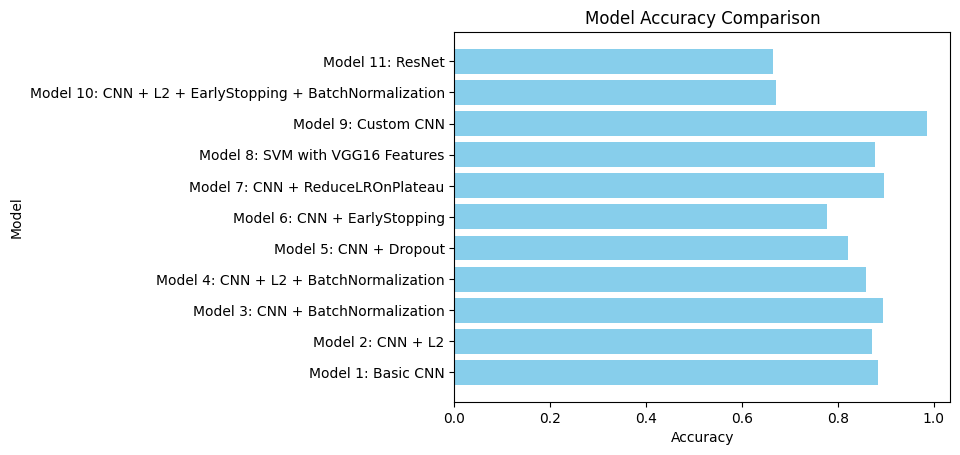

In [31]:
# Store results for comparison
results = {
    "Model 1: Basic CNN": {"accuracy": history_1.history['val_accuracy'][-1]},
    "Model 2: CNN + L2": {"accuracy": history_2.history['val_accuracy'][-1]},
    "Model 3: CNN + BatchNormalization": {"accuracy": history_3.history['val_accuracy'][-1]},
    "Model 4: CNN + L2 + BatchNormalization": {"accuracy": history_4.history['val_accuracy'][-1]},
    "Model 5: CNN + Dropout": {"accuracy": history_5.history['val_accuracy'][-1]},
    "Model 6: CNN + EarlyStopping": {"accuracy": history_6.history['val_accuracy'][-1]},
    "Model 7: CNN + ReduceLROnPlateau": {"accuracy": history_7.history['val_accuracy'][-1]},
    "Model 8: SVM with VGG16 Features": {"accuracy": accuracy_svm},  # Corrected to use accuracy_svm  #g
    "Model 9: Custom CNN": {"accuracy": history_9.history['val_accuracy'][-1]},
    "Model 10: CNN + L2 + EarlyStopping + BatchNormalization": {"accuracy": history_10.history['val_accuracy'][-1]},  # Corrected to use history_10  #g
    "Model 11: ResNet": {"accuracy": history_11.history['val_accuracy'][-1]}
}

# Plot results
names, accuracies = zip(*[(name, res["accuracy"]) for name, res in results.items()])
plt.barh(names, accuracies, color='skyblue')
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy Comparison")
plt.show()


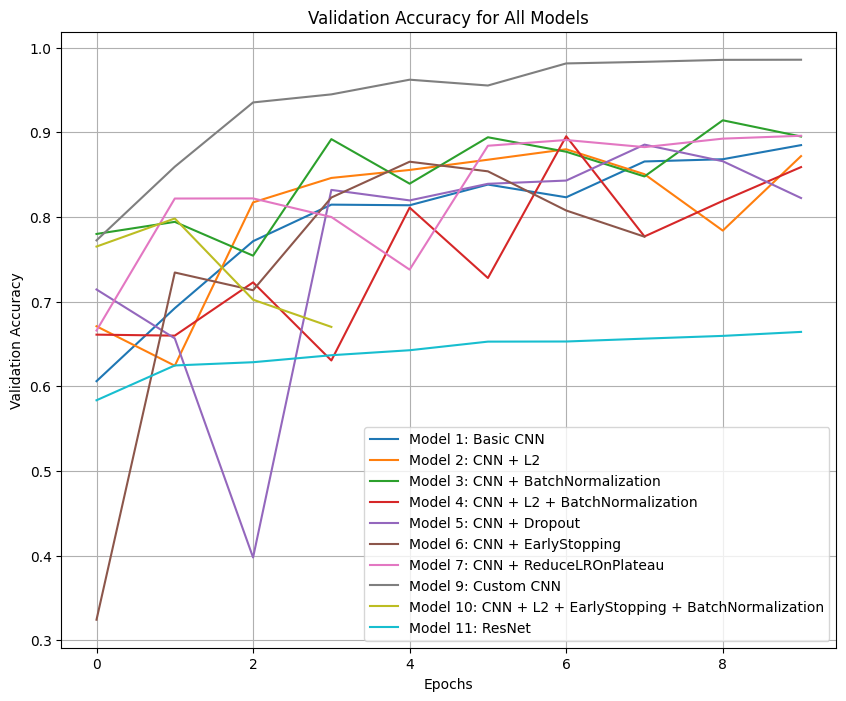

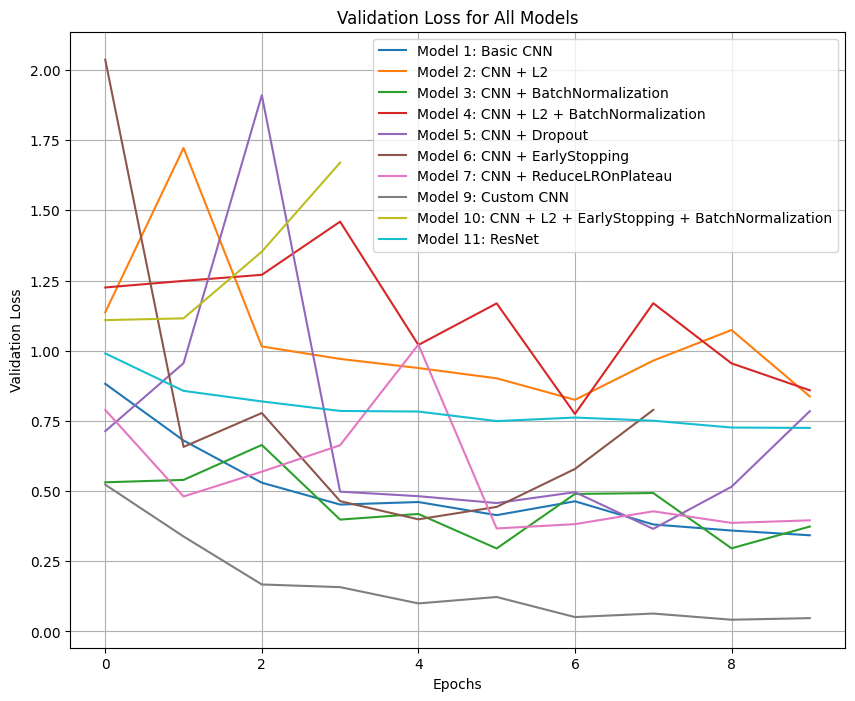

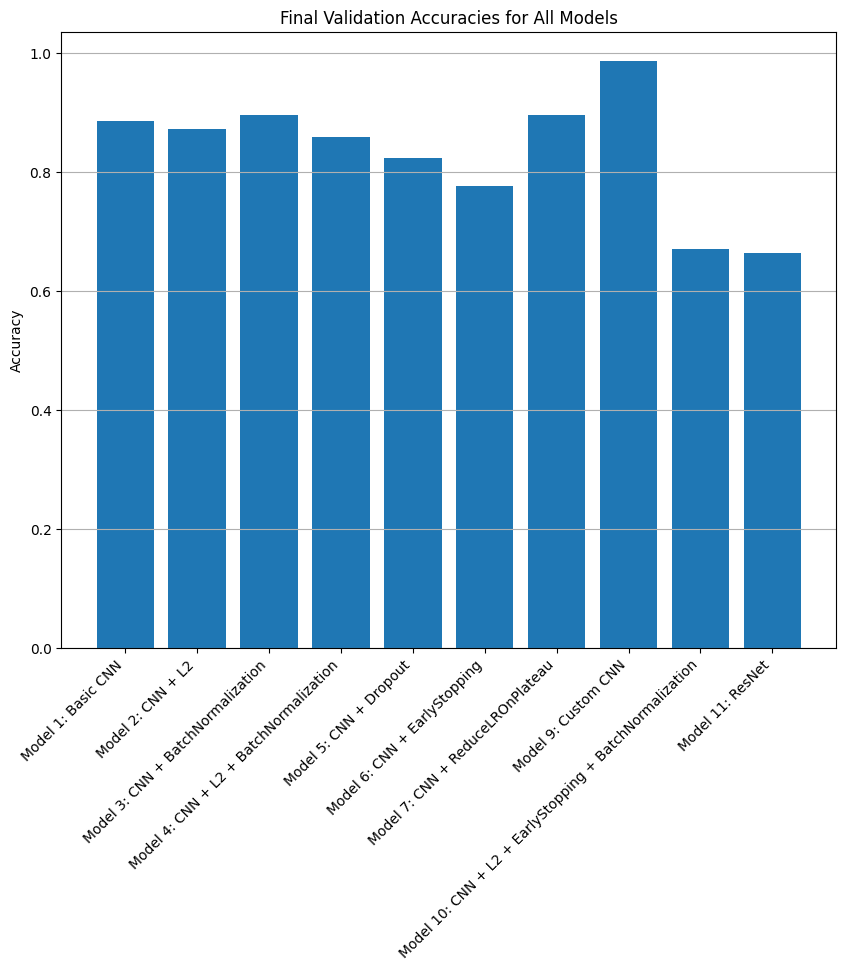

In [32]:
import matplotlib.pyplot as plt

# Collect all model histories for easier plotting
histories = {
    "Model 1: Basic CNN": history_1,
    "Model 2: CNN + L2": history_2,
    "Model 3: CNN + BatchNormalization": history_3,
    "Model 4: CNN + L2 + BatchNormalization": history_4,
    "Model 5: CNN + Dropout": history_5,
    "Model 6: CNN + EarlyStopping": history_6,
    "Model 7: CNN + ReduceLROnPlateau": history_7,
    "Model 9: Custom CNN": history_9, 
    "Model 10: CNN + L2 + EarlyStopping + BatchNormalization": history_10,
    "Model 11: ResNet": history_11
}

# Plot validation accuracy for all models
plt.figure(figsize=(10, 8))
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=model_name)

plt.title('Validation Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot validation loss for all models
plt.figure(figsize=(10, 8))
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=model_name)

plt.title('Validation Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Add bar chart for final accuracies
final_accuracies = {model: history.history['val_accuracy'][-1] for model, history in histories.items()}
plt.figure(figsize=(10, 8))
plt.bar(final_accuracies.keys(), final_accuracies.values())
plt.title('Final Validation Accuracies for All Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

2024-11-18 01:41:30.120507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━

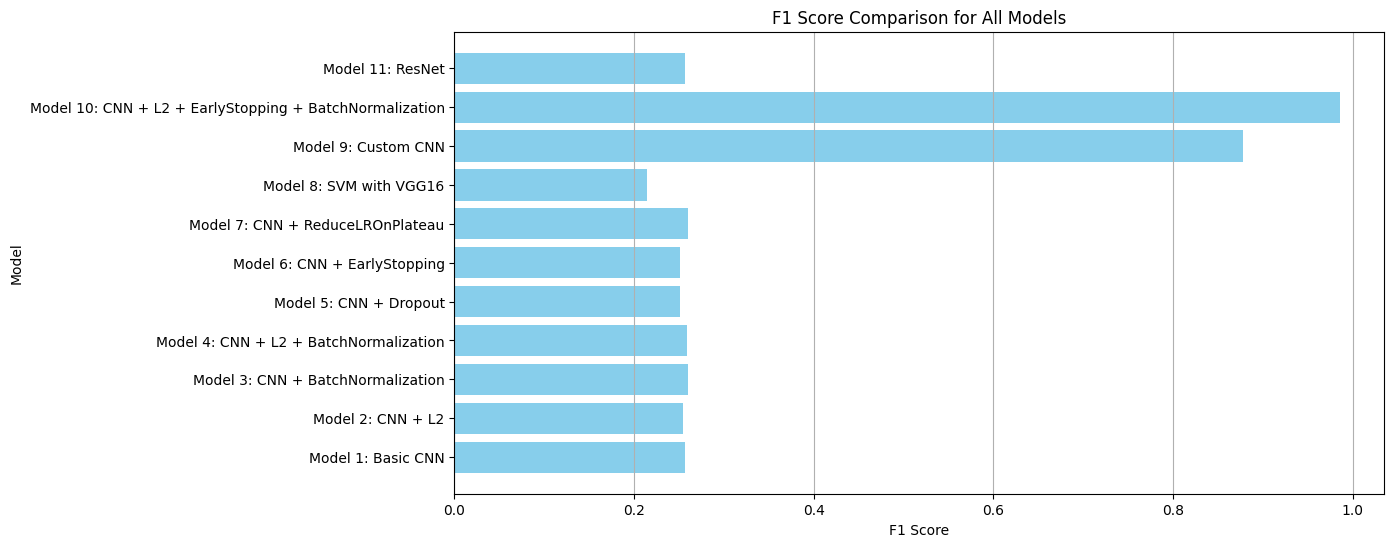

In [34]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

# Placeholder to store F1 scores for each model
f1_scores = []

# Compute F1 scores for Models 1-7 and Model 10
for i, model in enumerate([model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_10]):
    # Get predictions from the model
    val_predictions = np.argmax(np.vstack([model.predict(x) for x, _ in val_dataset]), axis=-1)
    val_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for _, y in val_dataset])

    # Calculate F1 score
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    f1_scores.append(f1)
    print(f"Model {i + 1} F1 Score: {f1:.4f}")

# Compute F1 score for Model 8 (SVM with VGG16)
f1_scores.append(svc_f1)
print(f"Model 8 (SVM with VGG16) F1 Score: {svc_f1:.4f}")

# Compute F1 score for Model 9
val_predictions_9 = np.argmax(model_9.predict(validation_images_9), axis=-1)
val_labels_9 = validation_images_9.classes  # Use ImageDataGenerator's classes for labels
f1_9 = f1_score(val_labels_9, val_predictions_9, average='weighted')
f1_scores.append(f1_9)
print(f"Model 9 (Custom CNN 224x224) F1 Score: {f1_9:.4f}")

# Compute F1 score for Model 11: ResNet
val_predictions_11 = np.argmax(np.vstack([model_11.predict(x) for x, _ in val_dataset]), axis=-1)
f1_11 = f1_score(val_labels, val_predictions_11, average='weighted')
f1_scores.append(f1_11)
print(f"Model 11 (ResNet) F1 Score: {f1_11:.4f}")

# Update model names
model_names_all = [
    "Model 1: Basic CNN",
    "Model 2: CNN + L2",
    "Model 3: CNN + BatchNormalization",
    "Model 4: CNN + L2 + BatchNormalization",
    "Model 5: CNN + Dropout",
    "Model 6: CNN + EarlyStopping",
    "Model 7: CNN + ReduceLROnPlateau",
    "Model 8: SVM with VGG16",
    "Model 9: Custom CNN",
    "Model 10: CNN + L2 + EarlyStopping + BatchNormalization",
    "Model 11: ResNet"
]

# Ensure the number of model names matches the number of F1 scores
assert len(model_names_all) == len(f1_scores), f"Mismatch! model_names_all={len(model_names_all)}; f1_scores={len(f1_scores)}"

# Plot F1 scores
plt.figure(figsize=(12, 6))
plt.barh(model_names_all, f1_scores, color='skyblue')
plt.title("F1 Score Comparison for All Models")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.grid(axis='x')
plt.show()



In [40]:
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
